In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

In [3]:
# declaring values

#######################################################################################################################################################################################
L = 5                          # length in m
B = 0.5                        # breadth in m
H = 0.5                        # height in m
E = 7E10                       # modulus of elasticity in N/m^4
D = 2700                       # density in Kg/m^3 
#######################################################################################################################################################################################

A = B*H                        # area in m^2
I = (B*H**3)/12                # area moment of inertia in m^4

In [4]:
def make_csv(data, name):
    df = pd.DataFrame(data)
    name += '.csv'  
    df.to_csv(name, index = None, header = None)

def make_stiffness_matrix(n):
    k_matrix = np.array([
        [12*E*I/(L/n)**3, 6*E*I/(L/n)**2, -12*E*I/(L/n)**3, 6*E*I/(L/n)**2],
        [6*E*I/(L/n)**2, 4*E*I/(L/n), -6*E*I/(L/n)**2, 2*E*I/(L/n)],
        [-12*E*I/(L/n)**3, -6*E*I/(L/n)**2, 12*E*I/(L/n)**3, -6*E*I/(L/n)**2],
        [6*E*I/(L/n)**2, 2*E*I/(L/n), -6*E*I/(L/n)**2, 4*E*I/(L/n)]
    ])
    
    stiffness_matrix = np.zeros((2*n + 2, 2*n + 2), dtype = 'float')
    i, j = 0, 0
    counti, countj = 0, 0

    while i < 2*n + 2:
        while j < 2*n + 2:
            stiffness_matrix[i][j] += k_matrix[counti][countj]
            j += 1
            countj += 1
            if countj == 4:
                if counti != 3:
                    i += 1
                    countj = 0
                    j -= 4
                    counti += 1
                    continue
                if counti == 3:
                    if i == 2*n + 1:
                        break
                    j -= 2
                    i -= 1
                    counti, countj = 0, 0
        break
    return stiffness_matrix
    
def make_mass_matrix(n):
    m_matrix = np.array([
       [13*A*(L/n)*D/35, 11*A*((L/n)**2)*D/210, 9*A*(L/n)*D/70, -13*A*((L/n)**2)*D/420],
       [11*A*((L/n)**2)*D/210, A*((L/n)**3)*D/105, 13*A*((L/n)**2)*D/420, -A*((L/n)**3)*D/140],
       [9*A*(L/n)*D/70, 13*A*((L/n)**2)*D/420, 13*A*(L/n)*D/35, -11*A*((L/n)**2)*D/210],
       [-13*A*((L/n)**2)*D/420, -A*((L/n)**3)*D/140, -11*A*((L/n)**2)*D/210, A*((L/n)**3)*D/105]
    ])
    
    mass_matrix = np.zeros((2*n + 2, 2*n + 2), dtype = 'float')
    i, j = 0, 0
    counti, countj = 0, 0

    while i < 2*n + 2:
        while j < 2*n + 2:
            mass_matrix[i][j] += m_matrix[counti][countj]
            j += 1
            countj += 1
            if countj == 4:
                if counti != 3:
                    i += 1
                    countj = 0
                    j -= 4
                    counti += 1
                    continue
                if counti == 3:
                    if i == 2*n + 1:
                        break
                    j -= 2
                    i -= 1
                    counti, countj = 0, 0
        break
    return mass_matrix


In [5]:
# CANTILEVER BEAM

N = 4                          # number of elements taken

STIFFNESS_MATRIX = make_stiffness_matrix(N)
# make_csv(STIFFNESS_MATRIX, "K")

MASS_MATRIX = make_mass_matrix(N)
# make_csv(MASS_MATRIX, "M")


STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 0)
STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 1)

MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 0)
MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 1)


evals, evecs = la.eigh(STIFFNESS_MATRIX, MASS_MATRIX)

# make_csv(evals, "evals")
# make_csv(evecs, "evecs")

frequencies = np.sqrt(evals)/(2*np.pi)
print(frequencies)



[  16.45097337  103.2132431   290.89863638  573.88020457 1067.38999024
 1714.23274704 2717.62784859 4459.05473526]


In [39]:
# MARIX
M = MASS_MATRIX
K = STIFFNESS_MATRIX
C = np.zeros((2*N, 2*N))
A = np.vstack([
    np.hstack([
        np.zeros((2*N, 2*N)), 
        np.eye(2*N, 2*N)
    ]), 
    np.hstack([
        -np.matmul(np.linalg.inv(M), K), 
        -np.matmul(np.linalg.inv(M), C)
    ])
])

B = np.vstack([np.zeros((2*N, 2*N)), np.linalg.inv(M)])


def F(t, y):

    Functions = np.zeros((2*N, 1))

########################################################################################################################################################################################
    Functions[-2] = 20*np.sin(2*np.pi*103.2132*t)
########################################################################################################################################################################################

    yvec = np.array([[y[i] for i in range(4*N)]]).T

    ydot = np.matmul(A, yvec) + np.matmul(B, Functions)

    return ydot

#######################################################################################################################################################################################
start_time = 0
end_time = 1
delta_t = 0.005
initial_conditions = np.zeros(4*N)
#######################################################################################################################################################################################

TE = np.arange(start_time, end_time, delta_t)

time_interval = np.array([start_time, end_time])

sol = solve_ivp(F, time_interval, initial_conditions, t_eval = TE, vectorized=True) #

T = sol.t
Y = sol.y


"""
print(len(Y), len(Y[0]))
make_csv(Y, 'y_25-elems_0to3-time_0.01-timestep_2cos175t-forcing')
make_csv(T, 't_25-elems_0to3-time_0.01-timestep_2cos175t-forcing')
"""

"\nprint(len(Y), len(Y[0]))\nmake_csv(Y, 'y_25-elems_0to3-time_0.01-timestep_2cos175t-forcing')\nmake_csv(T, 't_25-elems_0to3-time_0.01-timestep_2cos175t-forcing')\n"

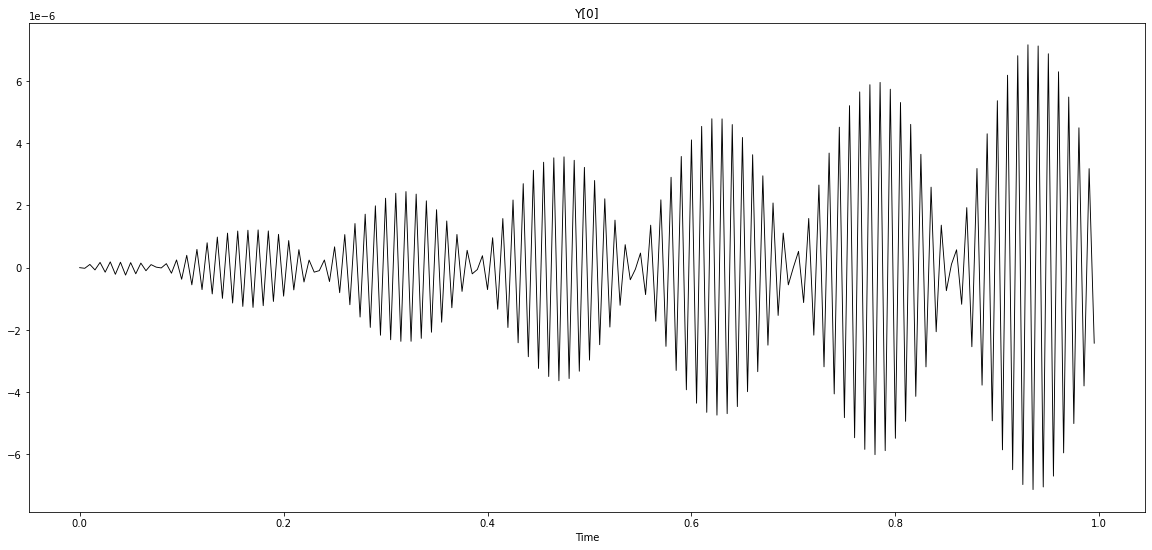

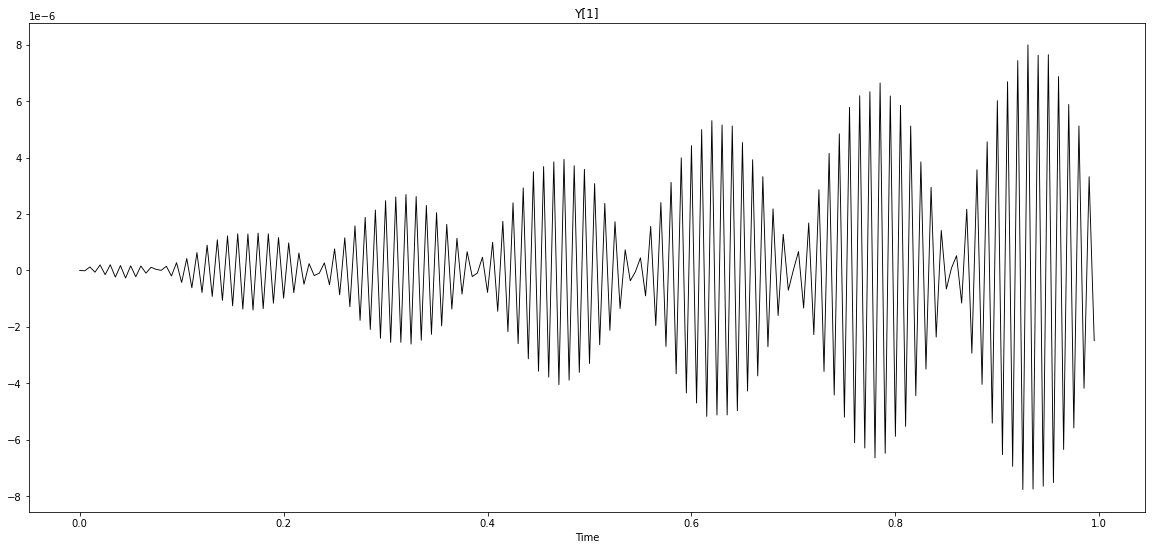

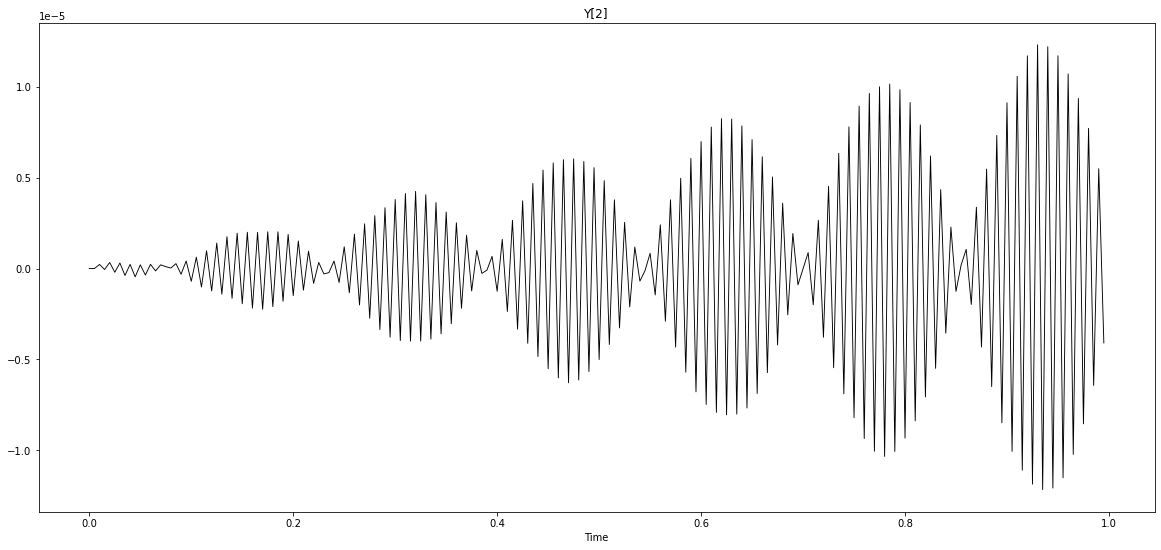

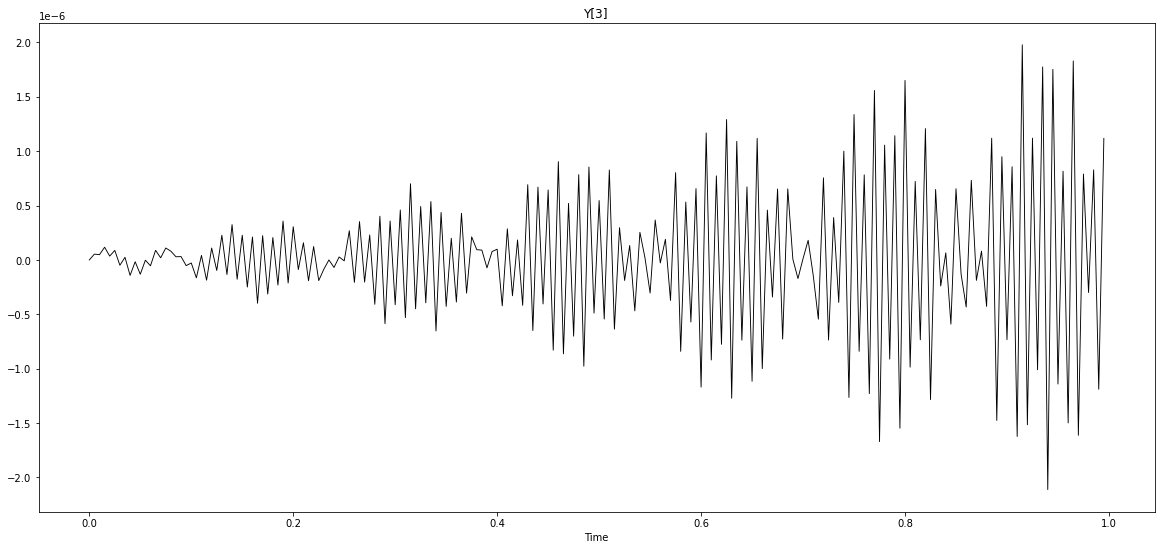

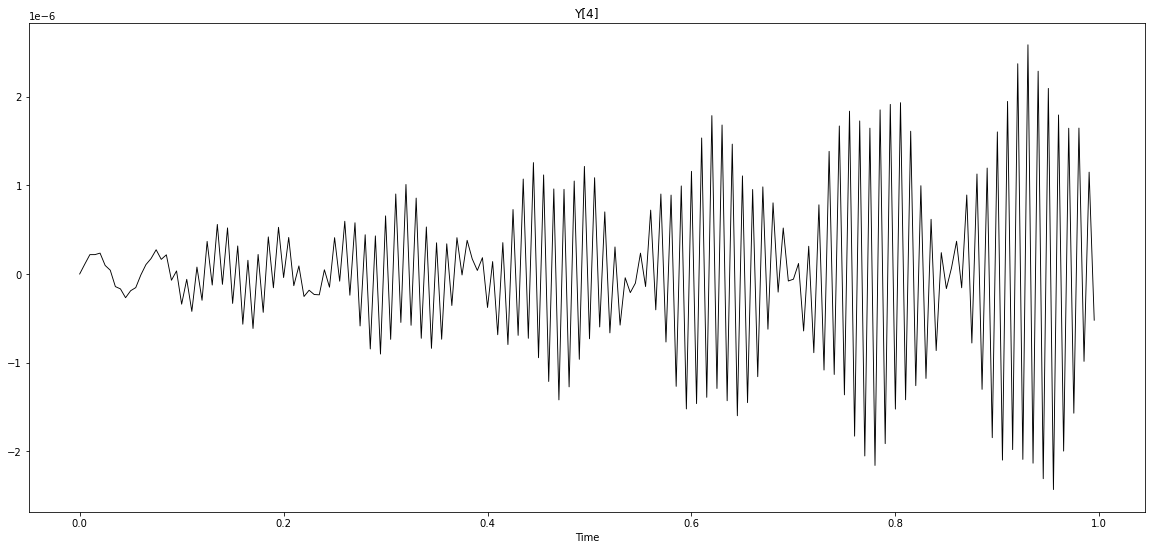

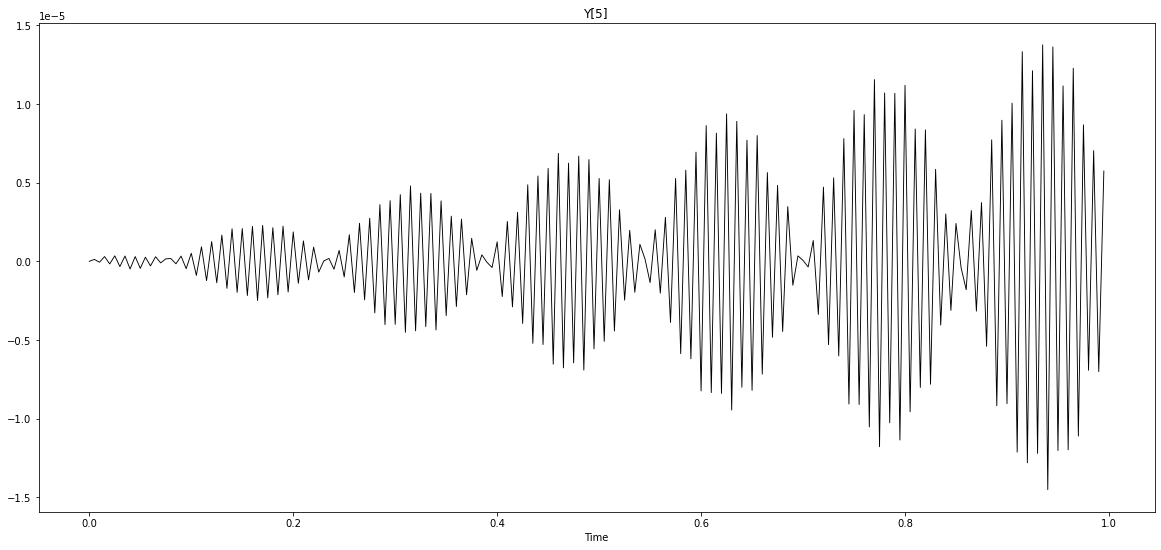

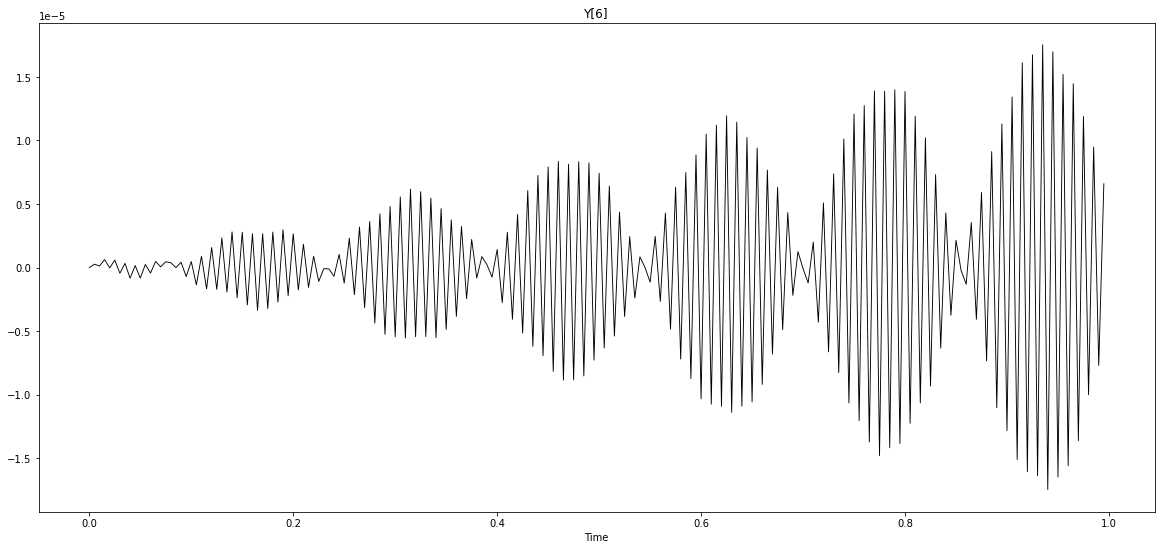

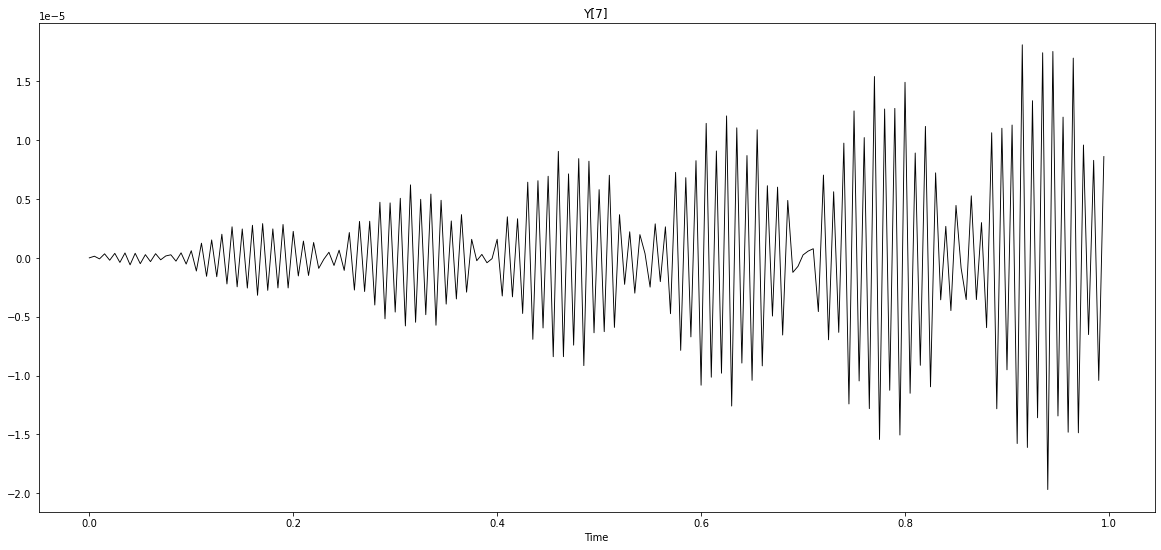

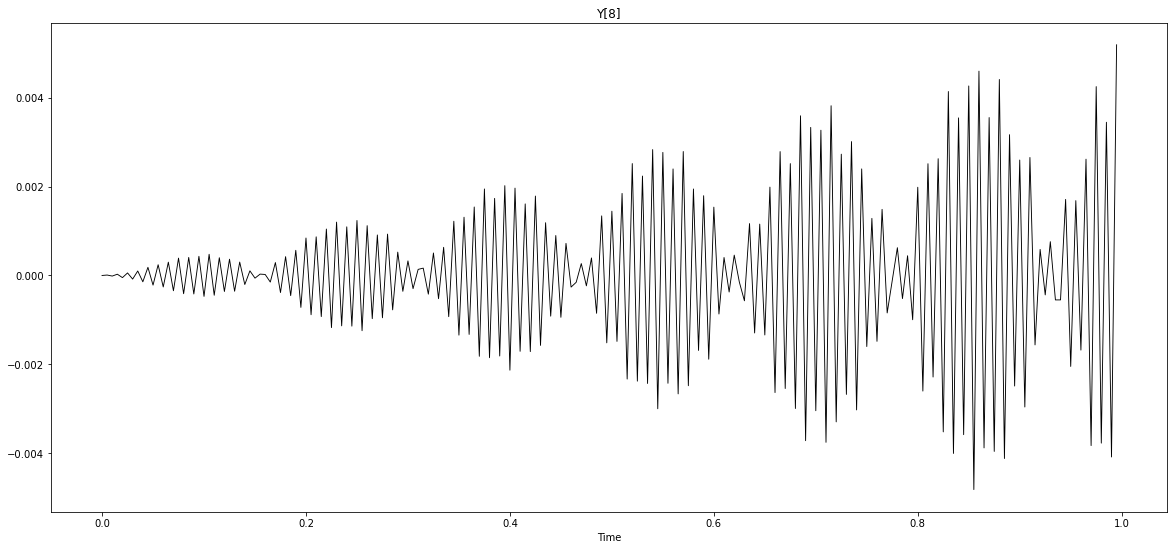

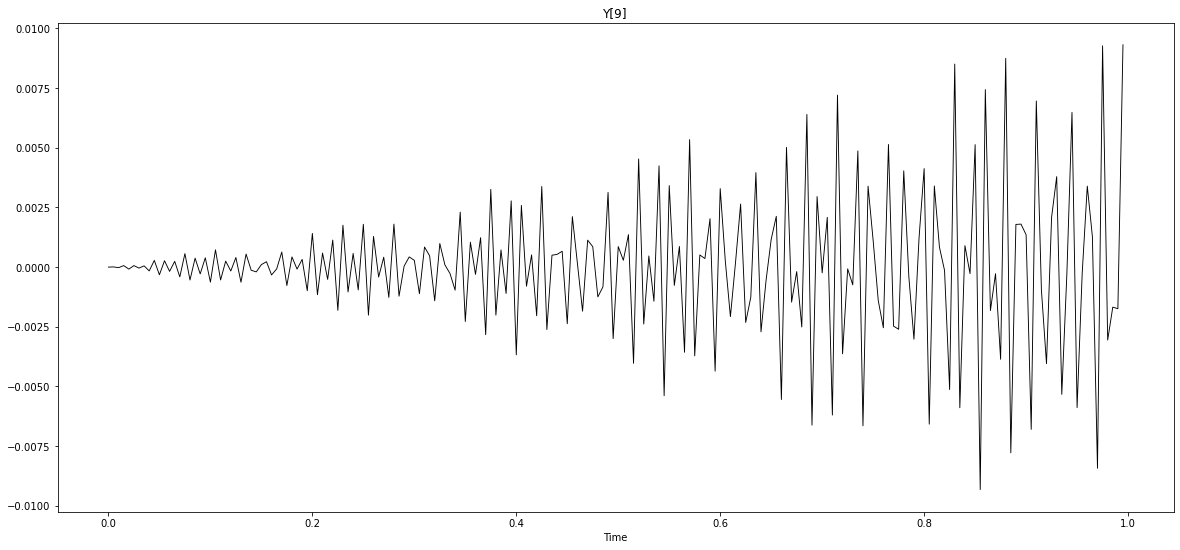

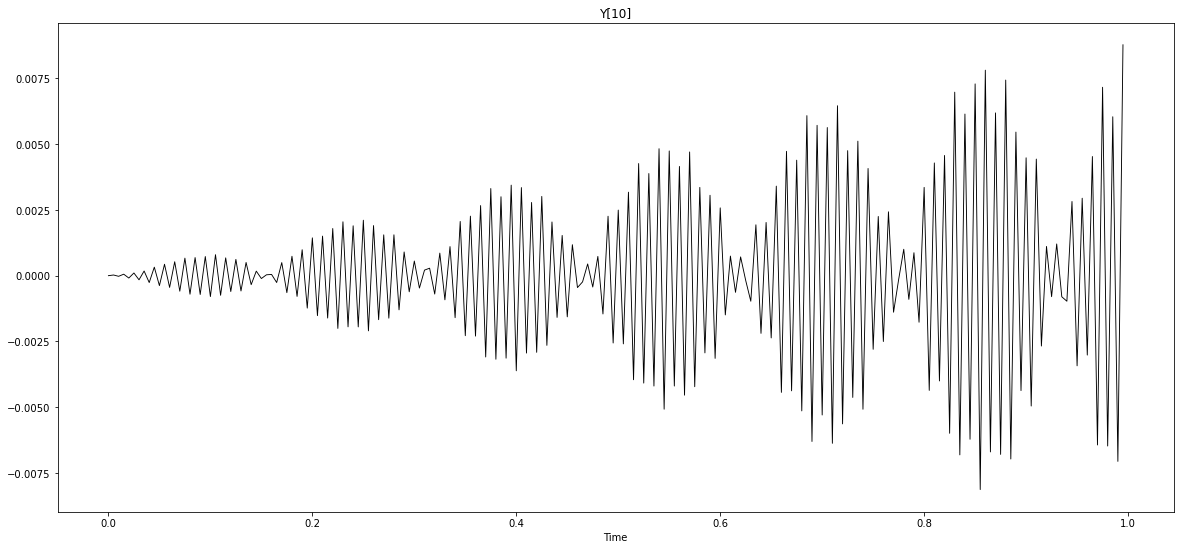

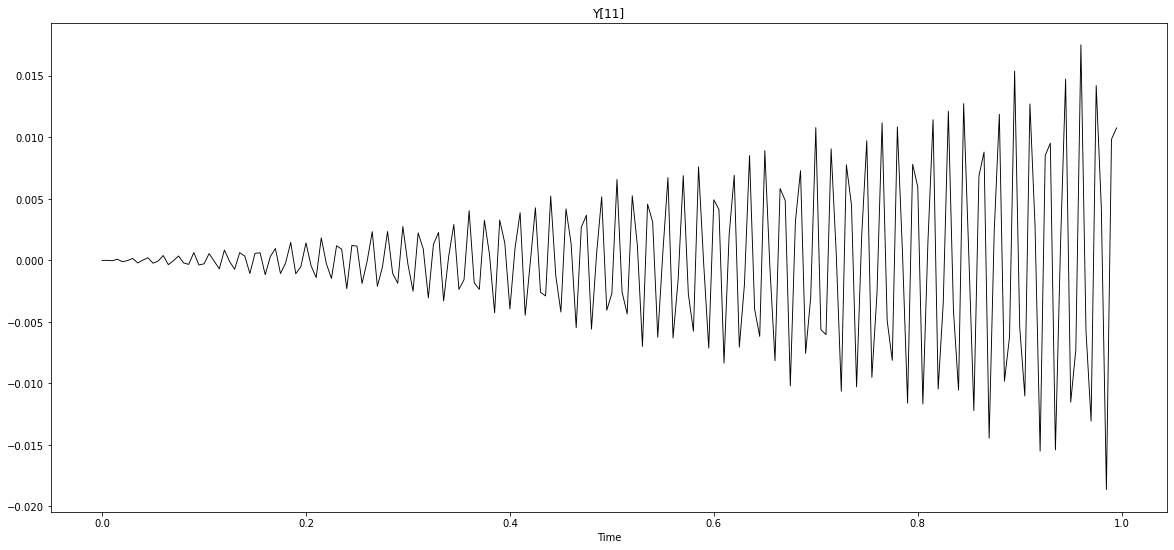

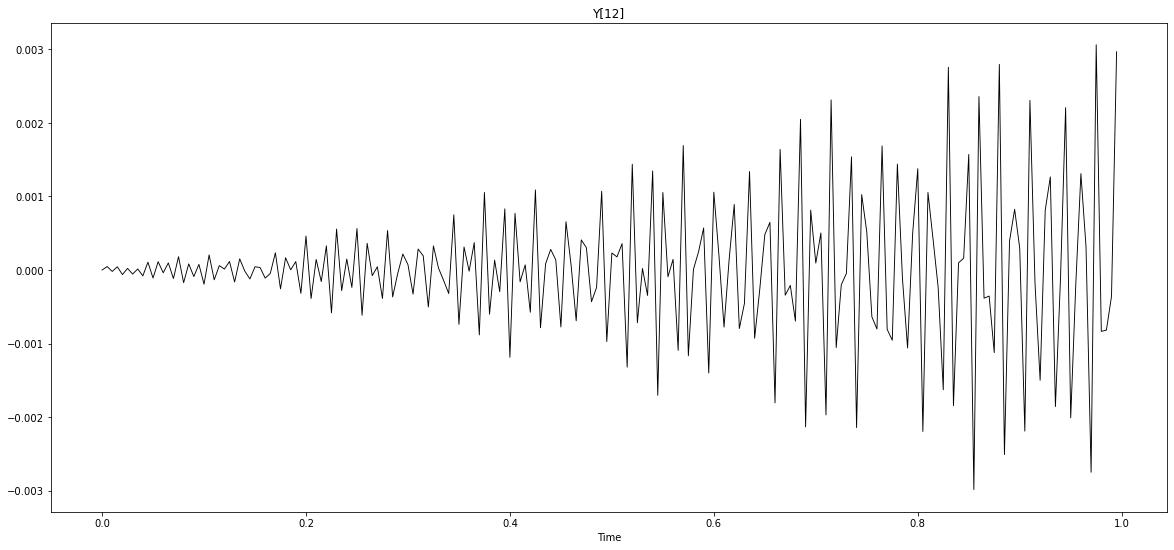

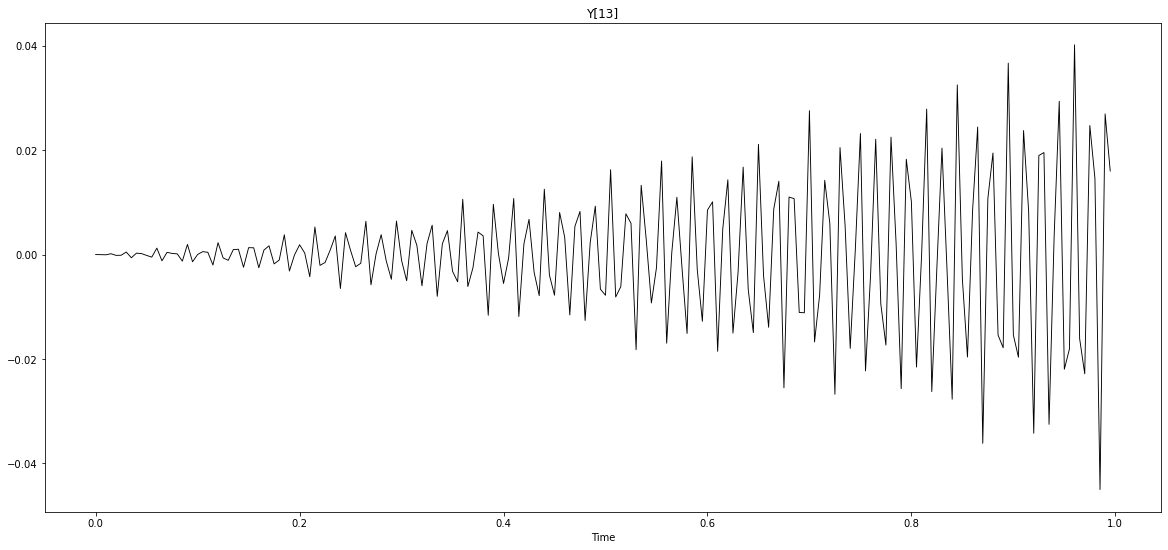

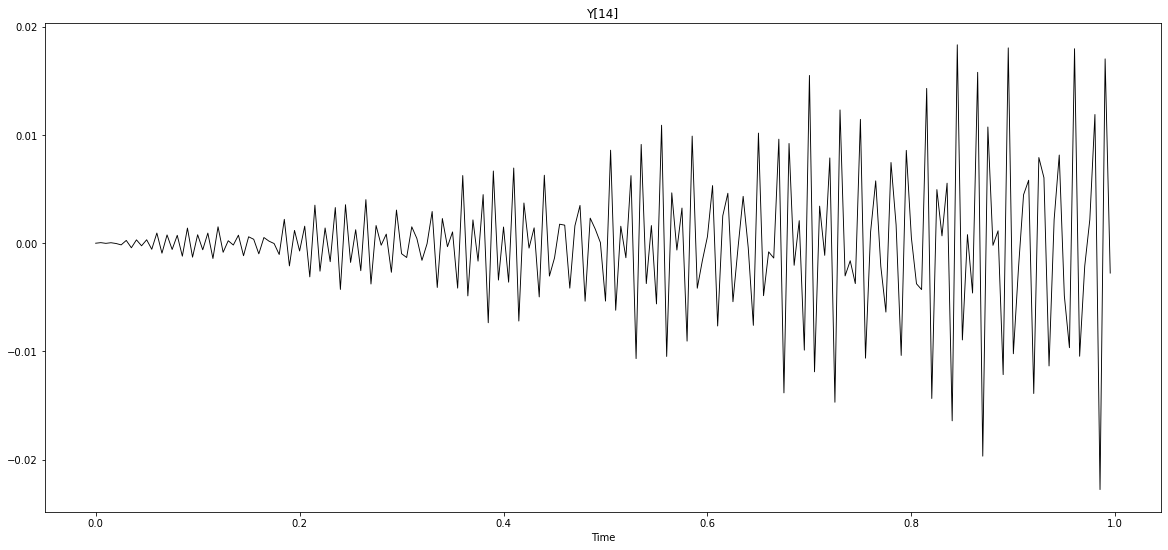

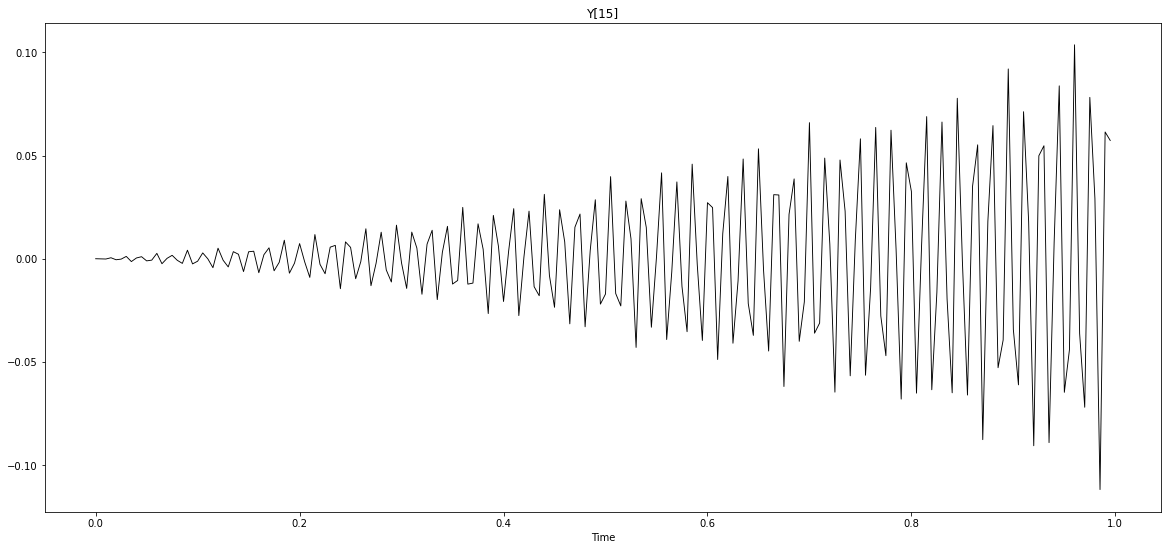

In [40]:
for i in range(len(Y)):
    plt.figure(figsize=(20, 9))
    plt.plot(T, Y[i], linewidth = 0.9, color = 'black')
    plt.title('Y['+ str(i)+']')
    plt.xlabel('Time')
    plt.show() 